In [1]:
import os
import sys
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from sklearn.preprocessing import Normalizer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH = 'moex_top.csv'
DEVICE = 'cpu'

In [3]:
data = pd.read_csv(PATH, index_col='date')
data.index = data.index.astype('datetime64[ns]')
data = data / data.shift(1) - 1
data = data.fillna(0)

In [4]:
universe_size = data.shape[1]

In [5]:
data.shape

(2520, 78)

In [6]:
"""
Example:

hidden_size = [64,32,16]

input => (64) => (16) => (64) => output

\------------------------/ \-------------------------/
       encoder                 decoder
"""

'\nExample:\n\nhidden_size = [64,32,16]\n\ninput => (64) => (16) => (64) => output\n\n\\------------------------/ \\-------------------------/\n       encoder                 decoder\n'

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self,n_features,hidden_sizes,activation_func):
        """
            hidden_sizes = [...]
        """
        super().__init__()
        
        encoder_layers = [nn.Linear(n_features,hidden_sizes[0]),activation_func()]
        for i in range(1,len(hidden_sizes)):
            encoder_layers += [nn.Linear(hidden_sizes[i-1],hidden_sizes[i]),activation_func()]
        self.encoder = nn.Sequential(*encoder_layers)
        
        decoder_layers = []
        for i in range(len(hidden_sizes)-1,0,-1):
            decoder_layers += [nn.Linear(hidden_sizes[i],hidden_sizes[i-1]),activation_func()]
        decoder_layers += [nn.Linear(hidden_sizes[0],n_features),activation_func()]
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self,x):
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        
        return x_decoded

In [8]:
model = AutoEncoder(universe_size,[8],nn.Tanh).to(DEVICE)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

Нормальлизуем данные методом sklearn.preprocessing.Normalizer()

100%|██████████| 1000/1000 [00:04<00:00, 225.01it/s]


0.009421158581972122


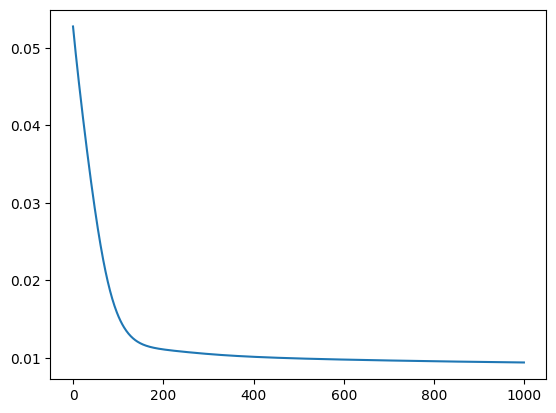

In [9]:
normalizer_transformer = Normalizer().fit(data)
data_norm = normalizer_transformer.transform(data)

data_norm = torch.tensor(data_norm,dtype=torch.float32).to(DEVICE)

losses = []

for _ in tqdm(range(1000)):
    predicted = model(data_norm)
    loss = loss_func(predicted,data_norm)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(losses)
print(losses[-1])

Используем первоначальный вид данных

100%|██████████| 10000/10000 [00:40<00:00, 249.35it/s]


0.00036890862975269556


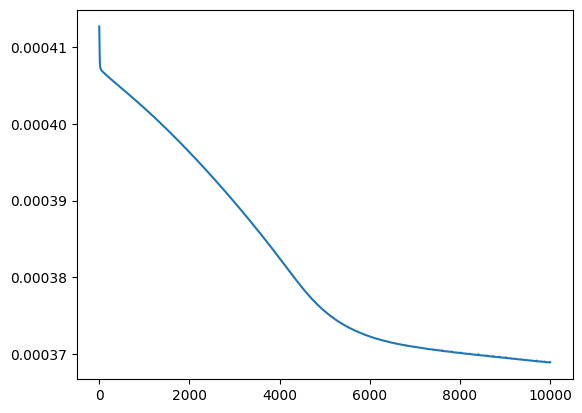

In [10]:
data = torch.tensor(data.values,dtype=torch.float32).to(DEVICE)
losses = []

for _ in tqdm(range(10000)):
    predicted = model(data)
    loss = loss_func(predicted,data)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(losses)
print(losses[-1])

тоже самое, только другое преобразование - tensor.normal_()

In [11]:
data.normal_()
losses = []

for _ in tqdm(range(1000)):
    predicted = model(data)
    loss = loss_func(predicted,data)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:04<00:00, 232.09it/s]


0.8714348673820496


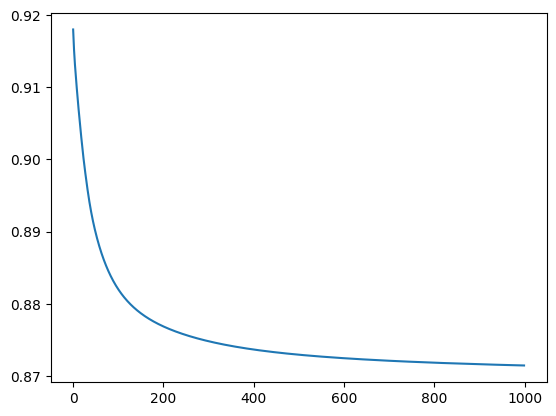

In [12]:
plt.plot(losses)
print(losses[-1])

Делаем вывод, что будем использовать первоначальные returns


In [13]:
data = pd.read_csv(PATH, index_col='date')
data.index = data.index.astype('datetime64[ns]')
data = data / data.shift(1) - 1
data = data.fillna(0)

In [14]:
realized_return = data
data = torch.tensor(data.values,dtype=torch.float32).to(DEVICE)
fair_return = pd.DataFrame(model(data).detach().numpy(), index=realized_return.index, columns=realized_return.columns)
data = pd.DataFrame(data, index=realized_return.index, columns=realized_return.columns)

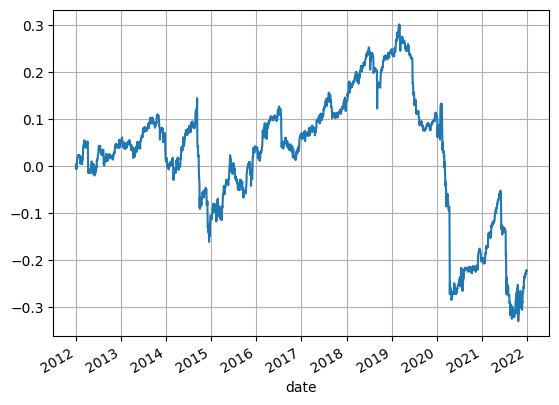

In [15]:
alpha = (fair_return-realized_return).shift().fillna(0)
alpha = alpha.sub(alpha.mean(axis=1),axis=0)
alpha = alpha.div(alpha.abs().sum(axis=1),axis=0)
(alpha*data).sum(axis=1).cumsum().plot()
plt.grid()

In [16]:
window = 40

alpha = dict()
for i,(date,row) in tqdm(enumerate(data.iterrows())):
    if i+1 < window:
        continue
    
    data_current = data.iloc[i-window+1:i+1]
    data_current_t = torch.tensor(data_current.values,dtype=torch.float32).to(DEVICE)
    
    model = AutoEncoder(universe_size,[8],nn.Tanh).to(DEVICE)
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    for _ in range(1000):
        predicted = model(data_current_t)
        loss = loss_func(predicted,data_current_t)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    realized_row = row.values
    fair_row = model(data_current_t).detach().numpy()[-1]
    
    alpha[date] = fair_row - realized_row

2520it [42:16,  1.01s/it]


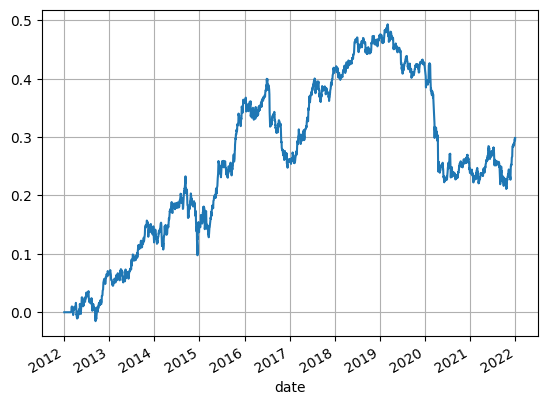

In [17]:
alpha_df = pd.DataFrame(alpha,index=data.columns).T
alpha_df = alpha_df.shift().reindex(data.index).fillna(0)
alpha_df = alpha_df.sub(alpha_df.mean(axis=1),axis=0)
alpha_df = alpha_df.div(alpha_df.abs().sum(axis=1),axis=0)
for _ in range(5):
    alpha_df = alpha_df.where(alpha_df.abs()<0.03,0.03*np.sign(alpha_df))
    alpha_df = alpha_df.sub(alpha_df.mean(axis=1),axis=0)
    alpha_df = alpha_df.div(alpha_df.abs().sum(axis=1),axis=0)

(alpha_df*data).sum(axis=1).cumsum().plot()
plt.grid()